# About this notebook. 

## This is a educational project which is based on the solution of [Bisman Preet Sign](https://medium.com/analytics-vidhya/predicting-sales-time-series-analysis-forecasting-with-python-b81d3e8ff03f) and his [github code](https://github.com/bisman16/Kaggle_Rossmann_Store_Sales_Forecasting/blob/master/Rossmann_Store_Analysis.ipynb). 

## In this notebook you will get insights about what is sales forecasting, all the steps respecting to  data cleaning, feature engineering, feature selection and the models used for the prediction. 


## Why sales forecasting?

### Predicting in advance the sales and inventory required at each store.

### This can prevent overstocking or understocking. 

### Analyze the performance of their stores. 

# **Steps for building a sales forecasting model**. 

# **Project** 

# Rossman store sales forecasting. 



## Rossman operates 3000 drug stores in 7 european countries. 

### The **main challenge** is to predict their daily sales for up to six weeks in advance. 


### There are some factors that can influence the sales such as promotions, competition, holidays, seasonality and locality. 

In [1]:
import os
import numpy as np
import pandas as pd, datetime
import seaborn as sns
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller
from time import time
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
from fbprophet import Prophet
from bokeh.plotting import figure , output_file, show, ColumnDataSource
from bokeh.io import push_notebook, show, output_notebook
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings('ignore')

Loading BokehJS ...

## **Data fields**

### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

#### Id - an Id that represents a (Store, Date) duple within the test set.

#### Store - a unique Id for each store

#### Sales - the turnover for any given day (this is what you are predicting)

#### Customers - the number of customers on a given day

#### Open - an indicator for whether the store was open: 0 = closed, 1 = open

#### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

#### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

#### StoreType - differentiates between 4 different store models: a, b, c, d

#### Assortment - describes an assortment level: a = basic, b = extra, c = extended

#### CompetitionDistance - distance in meters to the nearest competitor store

#### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

#### Promo - indicates whether a store is running a promo on that day

#### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

#### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

#### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Based on the previous information we have many stores each one of them with a unique id _(Store column)_. Each store can be closed (0) or open (1) _(Open column)_.  There are different types of stores **a**, **b** , **c** and **d** _(StoreType column)_ for which we have different assortment types **a** ,**b**, **c** _(Assortment column)_ .   

In [2]:
# Store data 
store = pd.read_csv('./data/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
store.shape

(1115, 10)

In [4]:
# Train data 
train = pd.read_csv('./data/train.csv', index_col='Date', parse_dates = True)
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [5]:
train.shape

(1017209, 8)

In [6]:
# Test data 
test = pd.read_csv('./data/test.csv', index_col='Date', parse_dates = True)
test.head()


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In [7]:
test.shape

(41088, 7)

# **Exploratory Data Analysis**

## Feature engineering. 

In [8]:
# Extracting year, month, day and week, and making new column
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales']/train['Customers']

In [9]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


## When were the stores closed?

In [10]:
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


## Which days were the store closed? 

array([[<AxesSubplot:title={'center':'DayOfWeek'}>]], dtype=object)

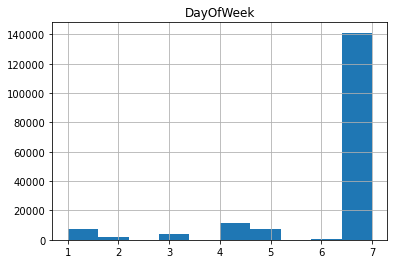

In [11]:
train_store_closed.hist('DayOfWeek')

### It seems that during the weekend, especially sundays.

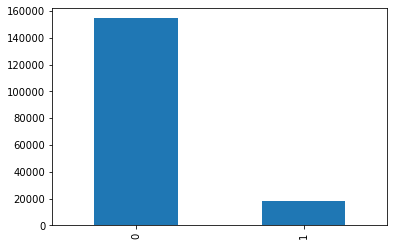

In [12]:
# Checking whether there was a school holiday when the store was closed
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar');

## Most of the days the store was closed is because a school holiday.

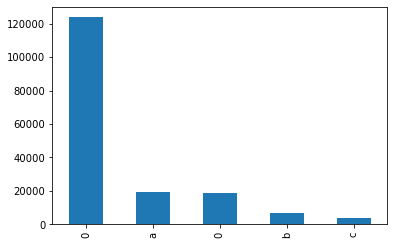

In [13]:

# Checking whether there was a state holiday when the store was closed
train_store_closed['StateHoliday'].value_counts().plot(kind='bar');

In [14]:
# Checking missing values in train set - no missing value
train.isnull().sum()

Store                   0
DayOfWeek               0
Sales                   0
Customers               0
Open                    0
Promo                   0
StateHoliday            0
SchoolHoliday           0
Year                    0
Month                   0
Day                     0
WeekOfYear              0
SalePerCustomer    172869
dtype: int64

In [15]:
# No. of days when store was opened but zero sales - might be because of external factors or refurbishmnent
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

## Handling missing values in the store dataframe. 

In [16]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

## For competition distance it can be use the median. But for the OPEN SINCE columns it would not work so 0 will be imputed. We will do the same with promo. 

In [17]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [18]:
# No info about other columns - so replcae by 0
store.fillna(0, inplace=True)

In [19]:
# Assuming stores open in test
test.fillna(1, inplace=True)

## Merging train and store tables. 

In [20]:

# Joining the tables
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## How many sales, sales per customer and number of customers we have by store type _(a,b,c,d)_?

In [21]:
train_store_joined.groupby('StoreType')['Customers', 'Sales', 'SalePerCustomer'].sum().sort_values('Sales', ascending=False)

,Customers,Sales,SalePerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


## How many stores are closed or their sales are zero?

In [22]:
# Closed and zero-sales obseravtions
train_store_joined[(train_store_joined.Open ==0) | (train_store_joined.Sales==0)].shape

(172871, 22)

## Dataframe which holds open stores and sales greater than 0. 

In [23]:
# Open & Sales >0 stores
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]

In [24]:
train_store_joined_open.groupby('StoreType')['Sales','SalePerCustomer'].sum().sort_values('Sales',ascending = False)

,Sales,SalePerCustomer
StoreType,,
a,3165334859,4.043129e+06
d,1765392943,2.918350e+06
c,783221426,9.744876e+05
b,159231395,7.987612e+04


## Stores a and d have the biggest sales, but stores c and d have the biggest sale by customer. 

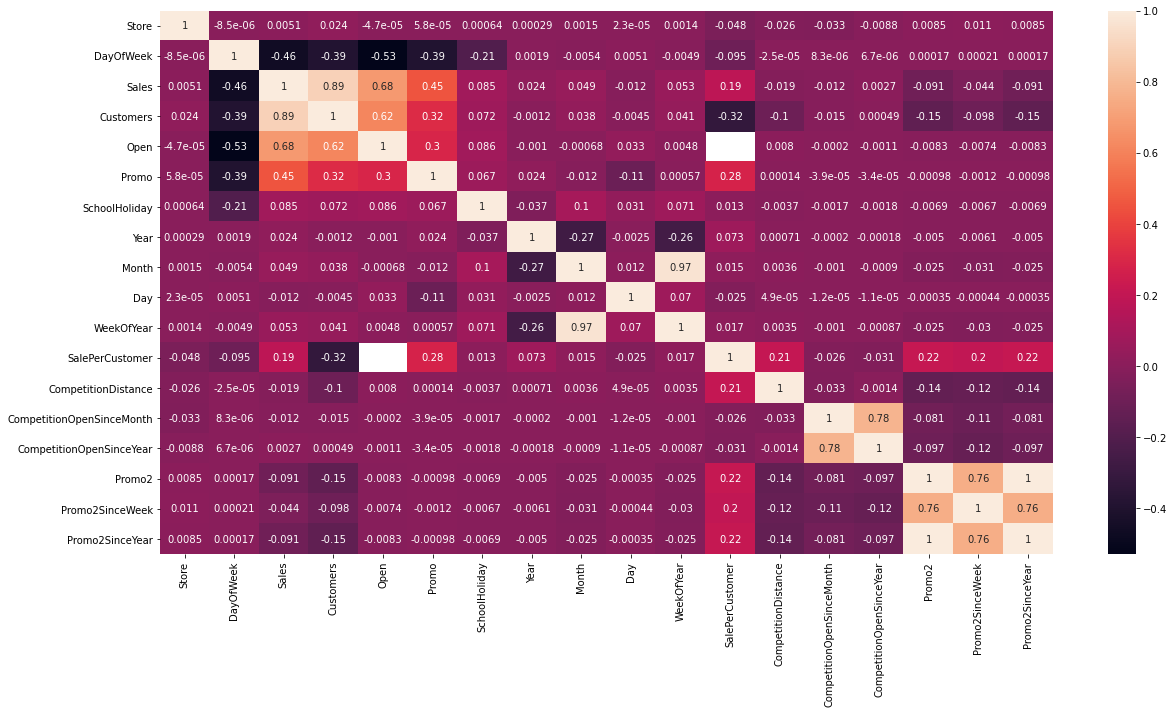

In [25]:
plt.figure(figsize = (20, 10))
sns.heatmap(train_store_joined.corr(), annot = True);

## There is a correlation between promo number 1 and sales. 

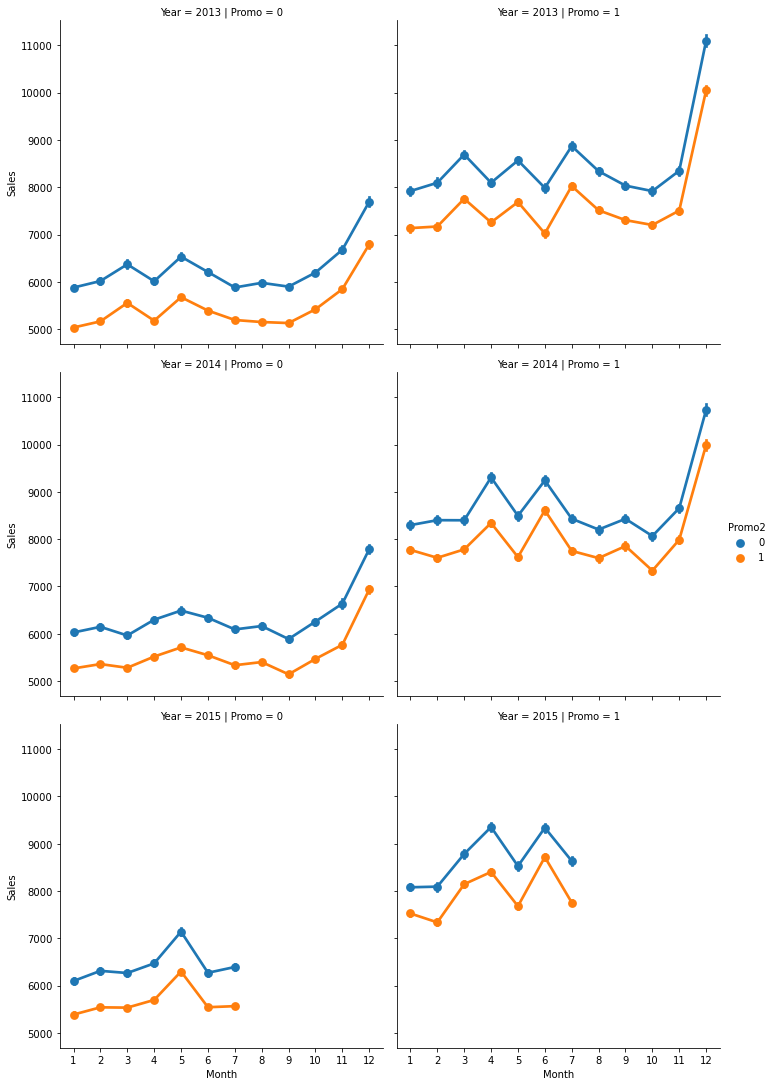

In [26]:
# Sales trend over the months
sns.factorplot(data = train_store_joined_open, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year"
             );

## Each row is a different year. The x axes represents the months and the y axes the sales. It can be seen that sales go up with promo and that they vary within the months so there are somo seasionality in the data. 

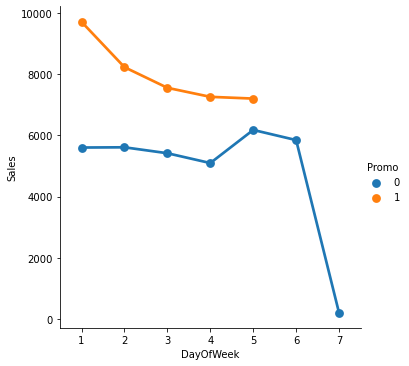

In [27]:
# Sales trend over days
sns.factorplot(data = train_store_joined, x = "DayOfWeek", y = "Sales", hue = "Promo")


### We can see from the trend that there are no promotions on the weekends i.e Saturday and Sunday, which makes sense as stores want to earn a maximum profit during the time when people do their house chores. The sales tend to increase on Sunday because people shop during the weekend. We can also see that the maximum sale happens on Mondays when there are promotional offers.

In [28]:
pd.plotting.register_matplotlib_converters()

## We will take a sample store for each type and analyze how the sales vary in a **weekly basis**.

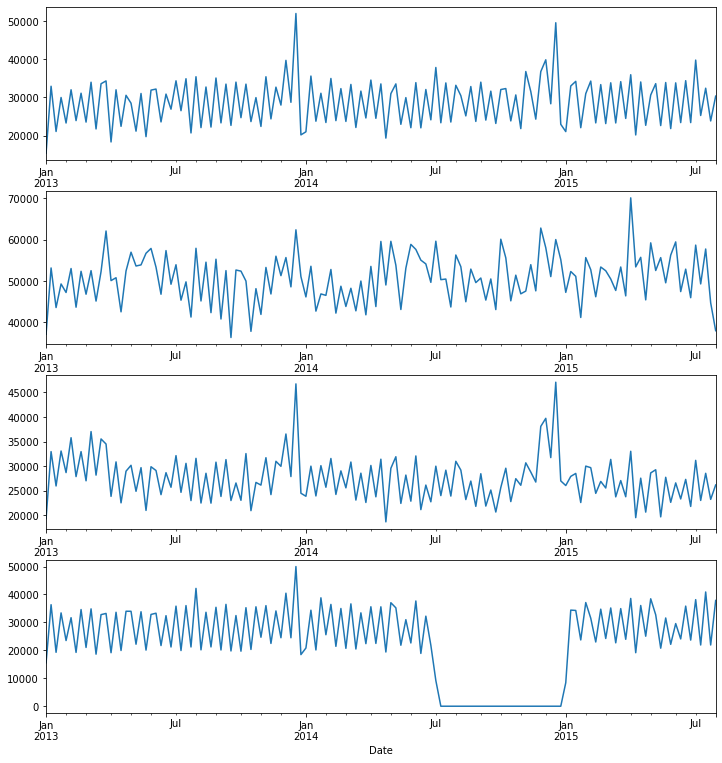

In [29]:
# Data Preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4);

## From above plots that sales for StoreType A and C tend to peak in the end of year (Christmas season). For StoreType B there is not a clear trend, maybe the store was closed by that time. 

# **Data modeling**

## In order to forecast the sales we need **stationary** data. This means that the data have constant mean, constant variance and constant covariance with time. 

### There are two methods one visualy and one with hypotesis testing for which we can see if the data is stationary:

1) Rolling mean:  A rolling analysis of a time series model is often used to assess the model's stability over time. The window is rolled (slide across the data) on a weekly basis, in which the average is taken on a weekly basis. Rolling Statistics is a visualization test, where we can compare the original data with the rolled data and check if the data is stationary or not.


2) Dicky -Fuller test: This test provides us the statistical data such as p-value to understand whether we can reject the null hypothesis. The null hypothesis is that data is not stationary and the alternative hypothesis says that data is stationary. If p-value is less than the critical value (say 0.5), we will reject the null hypothesis and say that data is stationary.



In [30]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Performing Dickey-Fuller test:
    print('Null hypotesis Ho: The data is not stationary')
    print('Alternative hypotesis H1: The data is stationary')
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)
    print('Based on the hypotesis test, using the p-value there is:')       
    if  result[1] <= 0.05:
        print('Strong evidence against the null hypothesis.')
    else:
        print('Weak evidence against the null hypothesis.')               

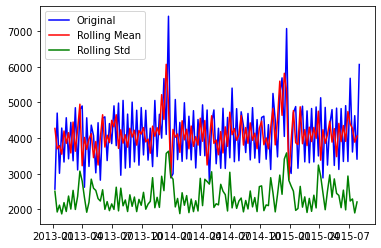

Null hypotesis Ho: The data is not stationary
Alternative hypotesis H1: The data is stationary
Results of Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
Based on the hypotesis test, using the p-value there is:
Strong evidence against the null hypothesis.


In [31]:
# Testing stationarity of store type a
test_stationarity(sales_a)

## Based on the results, the data is stationary so we dont need to implement any method to transform our data. 

## It's time to see the seasonality and the trends of the data during the months.

In [32]:
# Plotting seasonality and trend
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');
    axes[0].set_xlabel('months')
    axes[0].set_ylabel('sales')
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
    axes[1].set_xlabel('months')
    axes[1].set_ylabel('sales')

    plt.title('Decomposition Plots')

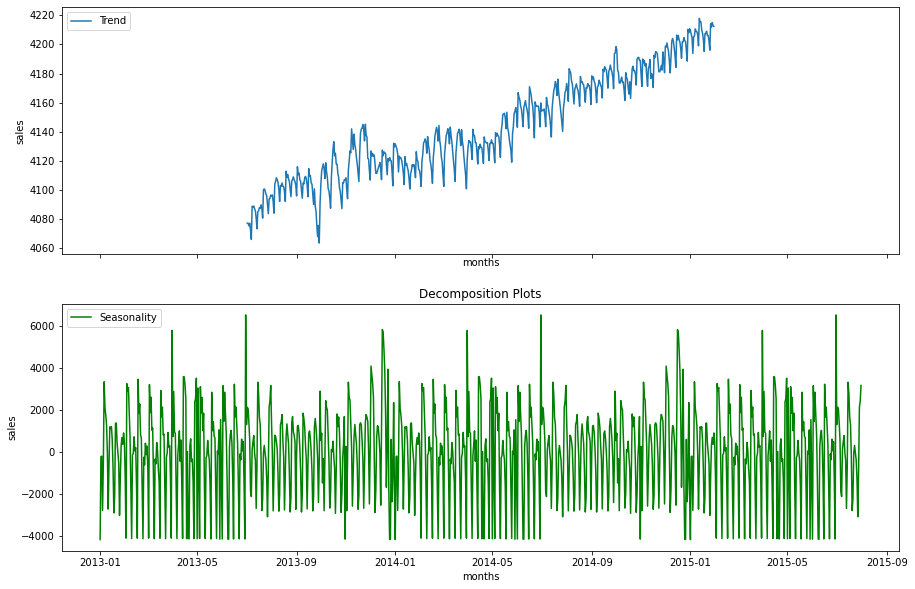

In [33]:
# Plotting seasonality and trend for store type a
plot_timeseries(sales_a,'a')

## The data is seasonal and there is a trend we can observe so we can use SARIMAX model and prophet model in order to forecast our data. 

# **Evaluation Metrics**

## **Mean Absolute Error (MAE)**: It is the average of the absolute difference between the predicted values and observed values.

## **Root Mean Square Error (RMSE)**: It is the square root of the average of squared differences between the predicted values and observed values.

### MAE is easier to understand and interpret but RMSE works well in situations where large errors are undesirable. This is because the errors are squared before they are averaged, thus penalizing large errors. In our case, RMSE suits well because we want to predict the sales with minimum error (i.e penalize high errors) so that inventory can be managed properly. So, we’ll choose RMSE as a metric to measure the performance of our models.

## In order to use this model, we need to first find out values of p, d and q. 

### **P** represents number of Autoregressive terms - lags of dependent variable. 

### **Q** represents number of Moving Average terms - lagged forecast errors in prediction equation. 

### **D** represents number of non-seasonal differences.

### To find the values of p, d and q - we use Autocorrelation function (ACF) and Partial Autocorrelation (PACF) plots.

### **ACF**  measure of correlation between time series with a lagged version of itself. 

### **PACF** measure of correlation between time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparison.

### **P** value is the value on x-axis of **PACF** where the plot crosses the **upper** Confidence Interval for the first time.

### **Q** value is the value on x-axis of **ACF** where the plot crosses the **upper** Confidence Interval for the first time.

In [34]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

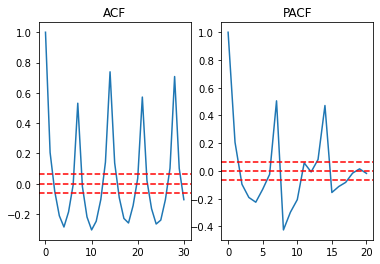

In [35]:
# ACF and PACF for store type a
auto_corr(sales_a)


## The above graphs suggest that the p = 2 and q = 2 but let's do a grid search and see which combination of p, q and d gives the lowest **Akaike Information Criterion** (AIC), which tells us the quality of statistical models for a given set of data. Best model uses the lowest number of features to fit the data.

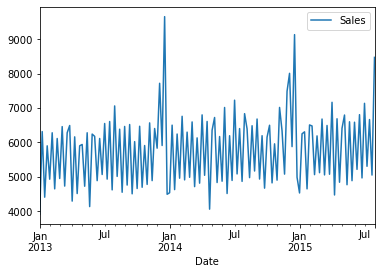

In [36]:
# Summing sales on per week basis
train_arima = train.resample("W").mean() 
train_arima = train_arima[["Sales"]]
train_arima.plot();

## This is how the sales change during the months taking in count the whole dataset. 

## We are going to implement a grid search to obtain the best p,q and d values. This values corresponds to the ones that derives in a lower AIC. 

In [37]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [38]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.2039807690517
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207662
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.822052279851
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.085669279766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.705791267357
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857757
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107370084
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.3366943416113
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.8868305023007
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.0171891135683
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.6353259669916
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.042617136146
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.908596277383
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.441508975179
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.8841842510296
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.58045319301
A

## From the above grid search that our optimal parameter combination is ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1806.2981906705384.

In [39]:
# Fitting the data to SARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                order=(1, 1, 1),# p,d,q
                                seasonal_order=(0, 1, 1, 12),# p,d,q, we are shifting by 12 during a season. 
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5251      0.103     -5.091      0.000      -0.727      -0.323
ma.L1         -0.9559      0.050    -19.076      0.000      -1.054      -0.858
ma.S.L12      -1.0120      0.831     -1.218      0.223      -2.640       0.616
sigma2      8.268e+05   7.31e+05      1.131      0.258   -6.06e+05    2.26e+06


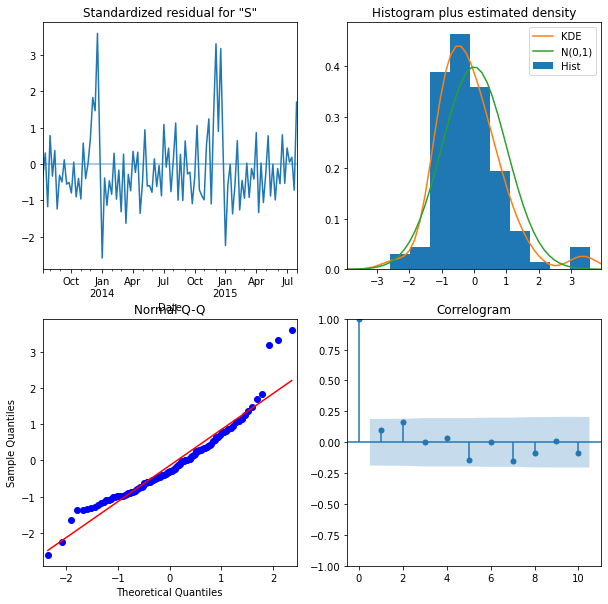

In [40]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()


## We can see from the above 'Histogram plus estimated density' plot that our KDE (Kernel Desnity Estimator) plot closely follows the N(0,1) normal distribution plot. The Normal Q-Q plot shows that the ordered distribution of residuals follows the distribution similar to normal distribution. Thus, our model seems to be pretty good.

## Standardized residual plot tells us that there is no major seasonality trend, which is confirmed by Correlogram (autocorrelation) plot. Autocorrelation plot tells us that the time series residuals have low correlation with lagged versions of itself.

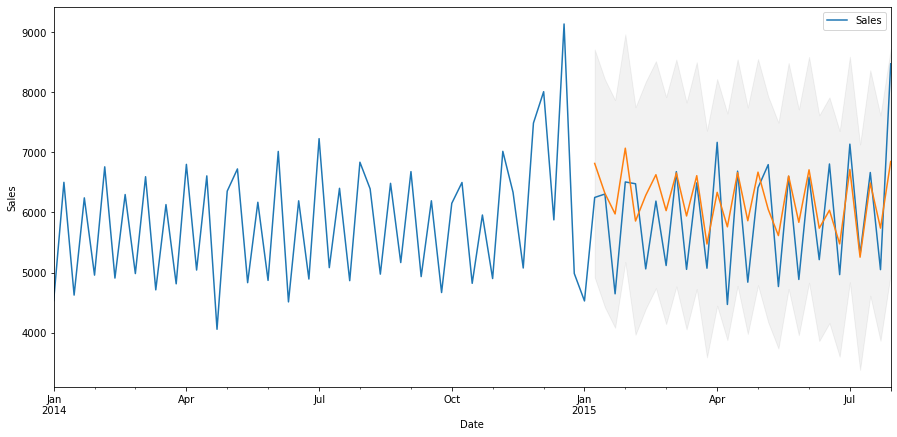

Root Mean Squared Error:  739.0611671149281


In [41]:
# Model Prediction and validation 
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False) 

# Get confidence intervals of forecasts
pred_ci = pred.conf_int() 

ax = train_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

# **Model 2 : Prophet by facebook**

In [42]:
# Creating a train dataset
train_prophet = train.copy()
train_prophet.reset_index(level=0, inplace=True)

In [43]:
train_prophet.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,2015-07-31,1,5,5263.0,555,1,1,0,1,2015,7,31,31,9.482883
1,2015-07-31,2,5,6064.0,625,1,1,0,1,2015,7,31,31,9.702400
2,2015-07-31,3,5,8314.0,821,1,1,0,1,2015,7,31,31,10.126675
3,2015-07-31,4,5,13995.0,1498,1,1,0,1,2015,7,31,31,9.342457
4,2015-07-31,5,5,4822.0,559,1,1,0,1,2015,7,31,31,8.626118


## The prophet model needs that the **date** column is named **ds** and the **sales** , or whatever we are forecasting, is named **y**. 

In [44]:
train_prophet = train_prophet.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
train_prophet.head()

,ds,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,2015-07-31,1,5,5263.0,555,1,1,0,1,2015,7,31,31,9.482883
1,2015-07-31,2,5,6064.0,625,1,1,0,1,2015,7,31,31,9.702400
2,2015-07-31,3,5,8314.0,821,1,1,0,1,2015,7,31,31,10.126675
3,2015-07-31,4,5,13995.0,1498,1,1,0,1,2015,7,31,31,9.342457
4,2015-07-31,5,5,4822.0,559,1,1,0,1,2015,7,31,31,8.626118



# **Hypertuning Prophet model**

## There are a lot of parameters available in the Prophet model. One of the most important ones is 'holidays'. This lets us pass holidays explicitly while training the model. We'll create a new 'holidays' data frame by taking observations when there was school or state holiday.

## We'll also use three more parameters viz.

### **Interval_width**: It defines the uncertainty level to make the prediction. The default value is 0.8 but we'll take 0.95 because we want to be certain in our predictions.

### **Growth**: We know that 'Sales' can take any value and there is no saturation point. So, we'll take 'linear' growth instead of 'logarithmic'.

### **Yearly_seasonality**: We'll explicitly pass it as 'True' because we know that there is a yearly seasonality (discussed above) present in our data.

In [45]:
# Encoding state holiday categorical variable
train_prophet["StateHoliday_cat"] = train_prophet["StateHoliday"].map({0:0, "0": 0, "a": 1, "b": 1, "c": 1})
train_prophet.head()

,ds,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,StateHoliday_cat
0,2015-07-31,1,5,5263.0,555,1,1,0,1,2015,7,31,31,9.482883,0
1,2015-07-31,2,5,6064.0,625,1,1,0,1,2015,7,31,31,9.702400,0
2,2015-07-31,3,5,8314.0,821,1,1,0,1,2015,7,31,31,10.126675,0
3,2015-07-31,4,5,13995.0,1498,1,1,0,1,2015,7,31,31,9.342457,0
4,2015-07-31,5,5,4822.0,559,1,1,0,1,2015,7,31,31,8.626118,0


In [46]:
# Choosing only required cols
train_prophet = train_prophet[['ds', 'y', 'SchoolHoliday', 'StateHoliday_cat']]
train_prophet.head()

,ds,y,SchoolHoliday,StateHoliday_cat
0,2015-07-31,5263.0,1,0
1,2015-07-31,6064.0,1,0
2,2015-07-31,8314.0,1,0
3,2015-07-31,13995.0,1,0
4,2015-07-31,4822.0,1,0


## Modeling the holidays data 

### First we are going to obtain which dates were state holidays and school holidays respectively.

### Second we will create two dataframes with that information labeling each data correspondingly.

### Third we will concatenate the two dataframes into the _holidays_ dataframe. 

In [47]:
# Modelling holidays - creating holidays dataframe
state_dates = train_prophet[(train_prophet.StateHoliday_cat == 1)].loc[:, "ds"].values
school_dates = train_prophet[(train_prophet.SchoolHoliday == 1)].loc[:, "ds"].values

state = pd.DataFrame({"holiday": "state_holiday",  "ds": pd.to_datetime(state_dates)})
school = pd.DataFrame({"holiday": "school_holiday", "ds": pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [48]:
# Dropping holiday columns because not needed any more
train_prophet_clean = train_prophet.drop(["SchoolHoliday", "StateHoliday_cat"], axis = 1)
train_prophet_clean.head()

,ds,y
0,2015-07-31,5263.0
1,2015-07-31,6064.0
2,2015-07-31,8314.0
3,2015-07-31,13995.0
4,2015-07-31,4822.0


# We are downsamplig to weekbasis. 

In [49]:
# Downsampling to week because modelling on daily basis takes a lot of time
ts_week_prophet = train_prophet_clean.set_index("ds").resample("W").sum()
ts_week_prophet.head()

,y
ds,
2013-01-06,26129335.0
2013-01-13,49275222.0
2013-01-20,34377765.0
2013-01-27,46040169.0
2013-02-03,38466029.0


In [50]:
# Resetting the index
ts_week_prophet_train = ts_week_prophet.reset_index()
ts_week_prophet_train.head()

,ds,y
0,2013-01-06,26129335.0
1,2013-01-13,49275222.0
2,2013-01-20,34377765.0
3,2013-01-27,46040169.0
4,2013-02-03,38466029.0


In [63]:
# Fitting data to Prophet model
prophet_2 = Prophet(holidays = holidays, interval_width = 0.95, growth='linear') 
prophet_2.fit(ts_week_prophet_train)
print("done")

future_2 = prophet_2.make_future_dataframe(periods = 52, freq = "W") 
forecast_2 = prophet_2.predict(future_2)

forecast_2[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail() # We have a new dataframe, which includes, the forecast and the uncertainity invervals.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


done


,ds,yhat,yhat_lower,yhat_upper
182,2016-07-03,4.414482e+07,3.017465e+07,5.871889e+07
183,2016-07-10,4.383939e+07,2.991842e+07,5.773979e+07
184,2016-07-17,4.410843e+07,2.912962e+07,5.780702e+07
185,2016-07-24,4.412159e+07,2.951900e+07,5.746089e+07
186,2016-07-31,4.352321e+07,2.817565e+07,5.702917e+07


In [64]:
forecast_2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,state_holiday,state_holiday_lower,state_holiday_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-06,4.360559e+07,1.325079e+07,4.151448e+07,4.360559e+07,4.360559e+07,-1.597119e+07,-1.597119e+07,-1.597119e+07,-1.309857e+07,...,-1.229775e+07,-1.229775e+07,-1.229775e+07,-2.872625e+06,-2.872625e+06,-2.872625e+06,0.0,0.0,0.0,2.763440e+07
1,2013-01-13,4.360648e+07,2.770518e+07,5.471023e+07,4.360648e+07,4.360648e+07,-2.365428e+06,-2.365428e+06,-2.365428e+06,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,-2.365428e+06,-2.365428e+06,-2.365428e+06,0.0,0.0,0.0,4.124105e+07
2,2013-01-20,4.360737e+07,2.976778e+07,5.789158e+07,4.360737e+07,4.360737e+07,-1.952600e+05,-1.952600e+05,-1.952600e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,-1.952600e+05,-1.952600e+05,-1.952600e+05,0.0,0.0,0.0,4.341211e+07
3,2013-01-27,4.360827e+07,3.081157e+07,5.780008e+07,4.360827e+07,4.360827e+07,1.240495e+06,1.240495e+06,1.240495e+06,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.240495e+06,1.240495e+06,1.240495e+06,0.0,0.0,0.0,4.484876e+07
4,2013-02-03,4.360916e+07,3.092467e+07,5.935179e+07,4.360916e+07,4.360916e+07,1.176155e+06,1.176155e+06,1.176155e+06,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.176155e+06,1.176155e+06,1.176155e+06,0.0,0.0,0.0,4.478531e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2016-07-03,4.384311e+07,3.017465e+07,5.871889e+07,4.383570e+07,4.385114e+07,3.017094e+05,3.017094e+05,3.017094e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,3.017094e+05,3.017094e+05,3.017094e+05,0.0,0.0,0.0,4.414482e+07
183,2016-07-10,4.384478e+07,2.991842e+07,5.773979e+07,4.383713e+07,4.385299e+07,-5.394328e+03,-5.394328e+03,-5.394328e+03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,-5.394328e+03,-5.394328e+03,-5.394328e+03,0.0,0.0,0.0,4.383939e+07
184,2016-07-17,4.384646e+07,2.912962e+07,5.780702e+07,4.383859e+07,4.385490e+07,2.619757e+05,2.619757e+05,2.619757e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,2.619757e+05,2.619757e+05,2.619757e+05,0.0,0.0,0.0,4.410843e+07
185,2016-07-24,4.384813e+07,2.951900e+07,5.746089e+07,4.384005e+07,4.385678e+07,2.734521e+05,2.734521e+05,2.734521e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,2.734521e+05,2.734521e+05,2.734521e+05,0.0,0.0,0.0,4.412159e+07


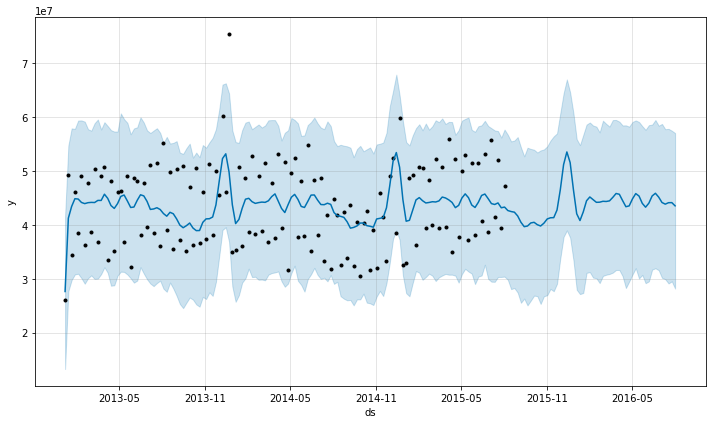

In [65]:
# Visualizing predicions of forecast
prophet_2.plot(forecast_2);

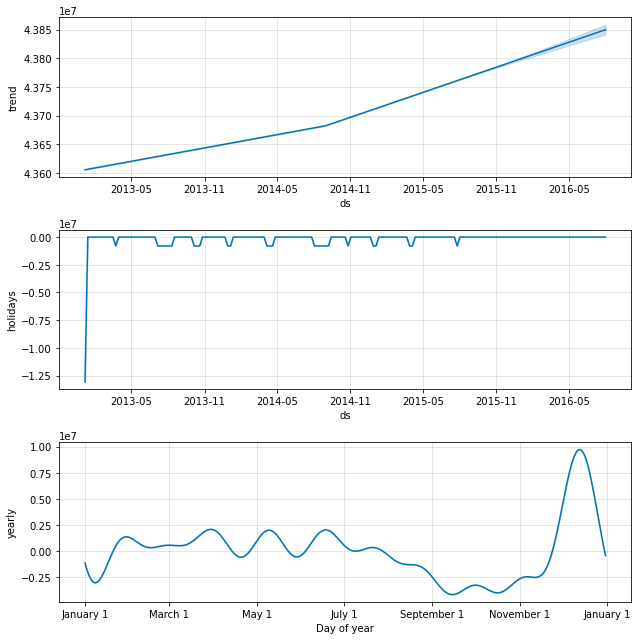

In [66]:
# Visualizing trend and seasonality components
prophet_2.plot_components(forecast_2);

## The trend of the sales goes up as shown in the first graph. The second graph shows the holidays gap and  finally during December the sales go up. 

In [67]:
# Checking the RMSE of Prophet model
metric_prophet_2 = forecast_2.set_index('ds')[['yhat']].join(ts_week_prophet_train.set_index('ds').y).reset_index()
metric_prophet_2.dropna(inplace=True)
rms_prophet_2 = mean_squared_error(metric_prophet_2.y, metric_prophet_2.yhat)
rms_prophet_2

52478290246950.99

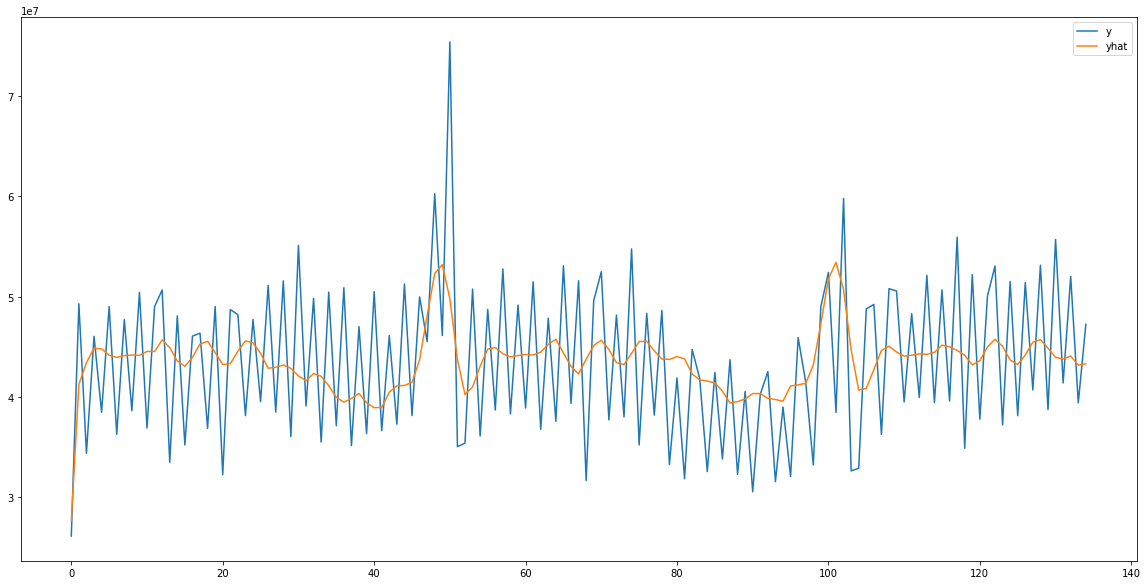

In [68]:
# Visualizing the performance of model
plt.figsize=(10,20)
metric_prophet_2["y"].plot(figsize=(20,10))
metric_prophet_2["yhat"].plot()
plt.legend()
plt.show()

# **Model 3 XGBoost** 

## Data preprocesing. 

In [52]:
# Dropping Customers and Sale per customer
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalePerCustomer', 'PromoInterval'], axis=1) # axis 1 refer to columns. 

In [53]:
# Combining similar columns into one column and dropping old columns
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekOfYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)

In [54]:
ts_xgboost.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,CompetitionOpen,PromoOpen
0,1,5,5263,1,1,0,1,2015,7,31,31,c,a,1270.0,0,82.0,24187.75
1,1,4,5020,1,1,0,1,2015,7,30,31,c,a,1270.0,0,82.0,24187.75
2,1,3,4782,1,1,0,1,2015,7,29,31,c,a,1270.0,0,82.0,24187.75
3,1,2,5011,1,1,0,1,2015,7,28,31,c,a,1270.0,0,82.0,24187.75
4,1,1,6102,1,1,0,1,2015,7,27,31,c,a,1270.0,0,82.0,24187.75


In [55]:
# Converting categorical cols to numerical cols and removing old cols
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)

In [56]:
ts_xgboost.head()

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,Promo2,CompetitionOpen,PromoOpen,StateHoliday_cat,StoreType_cat,Assortment_cat
0,1,5,5263,1,1,1,2015,7,31,31,1270.0,0,82.0,24187.75,0,1.0,1
1,1,4,5020,1,1,1,2015,7,30,31,1270.0,0,82.0,24187.75,0,1.0,1
2,1,3,4782,1,1,1,2015,7,29,31,1270.0,0,82.0,24187.75,0,1.0,1
3,1,2,5011,1,1,1,2015,7,28,31,1270.0,0,82.0,24187.75,0,1.0,1
4,1,1,6102,1,1,1,2015,7,27,31,1270.0,0,82.0,24187.75,0,1.0,1


## Spliting the data into train and test. 

In [57]:
# Splitting the data
features = ts_xgboost.drop(["Sales"], axis = 1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20)

In [58]:
# Tuning parameters - using default metrics
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'} 

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[12:03:00] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5162.91406	eval-rmse:5173.15723
[1]	train-rmse:4011.37036	eval-rmse:4024.38257
[2]	train-rmse:3296.31665	eval-rmse:3310.75342
[3]	train-rmse:2876.56030	eval-rmse:2891.58667
[4]	train-rmse:2639.12231	eval-rmse:2654.79492
[5]	train-rmse:2503.38599	eval-rmse:2518.29492
[6]	train-rmse:2417.15991	eval-rmse:2432.45532
[7]	train-rmse:2339.22070	eval-rmse:2353.39844
[8]	train-rmse:2294.14356	eval-rmse:2307.63916
[9]	train-rmse:2274.10132	eval-rmse:2287.39795
[10]	train-rmse:2254.26733	eval-rmse:2268.15259
[11]	train-rmse:2220.22461	eval-rmse:2233.43750
[12]	train-rmse:2206.36816	eval-rmse:2220.02637
[13]	train-rmse:2199.91650	eval-rmse:2213.46606
[14]	train-rmse:2174.50830	eval-rmse:2186.75317
[15]	train-rmse:2149.27808	eval-rmse:2160.68408
[16]	train-rmse:2098.10669	eval-rmse:2108.82544
[17]	train-rmse:2056.63477	eval-rmse:2

In [59]:
# RMSE of model
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 1246.580778534937


## Hyperparameter tuning for XGBoost. 

## Now let's try to decrease the RMSE of XGBoost by passing different values for our hyperparameters in the XGBoost model.

### *eta: It defines the learning rate i.e step size to learn the data in the gradient descent modeling (the basis for XGBoost). The default value is 0.3 but we want to keep the learning rate low to avoid overfitting. So, we'll choose 0.1 as eta.

### *max_depth: Maximum depth of a tree. The default value is 6 but we want our model to be more complex and find good predictions. So, let's choose 10 as max depth.

### * gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. The default value is 0, let's choose a little higher value so as to get good predictions

In [60]:
# Tuning parameters
params_2 = {'max_depth':10, 'eta':0.1,  'gamma': 2}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost_2 = xgb.train(params_2, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds_2 = xgboost_2.predict(dtest)

[0]	train-rmse:6323.89355	eval-rmse:6331.88770
[1]	train-rmse:5777.29883	eval-rmse:5786.37061
[2]	train-rmse:5291.21484	eval-rmse:5301.37061
[3]	train-rmse:4862.10059	eval-rmse:4873.61230
[4]	train-rmse:4481.90723	eval-rmse:4494.70801
[5]	train-rmse:4148.88818	eval-rmse:4163.21631
[6]	train-rmse:3855.33936	eval-rmse:3870.68433
[7]	train-rmse:3595.66089	eval-rmse:3611.62500
[8]	train-rmse:3371.85107	eval-rmse:3388.84839
[9]	train-rmse:3175.00732	eval-rmse:3193.35278
[10]	train-rmse:3007.27539	eval-rmse:3027.10767
[11]	train-rmse:2865.16406	eval-rmse:2886.20752
[12]	train-rmse:2740.72070	eval-rmse:2762.62842
[13]	train-rmse:2632.23633	eval-rmse:2655.12012
[14]	train-rmse:2532.26587	eval-rmse:2555.60644
[15]	train-rmse:2457.61206	eval-rmse:2482.31519
[16]	train-rmse:2383.56616	eval-rmse:2408.34668
[17]	train-rmse:2325.03980	eval-rmse:2350.61426
[18]	train-rmse:2269.18872	eval-rmse:2294.99487
[19]	train-rmse:2230.28369	eval-rmse:2256.68115
[20]	train-rmse:2187.97998	eval-rmse:2214.70776
[2

In [61]:
# RMSE of model
rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))
print("Root Mean Squared Error for XGBoost:", rms_xgboost_2)

Root Mean Squared Error for XGBoost: 1178.5067936106245


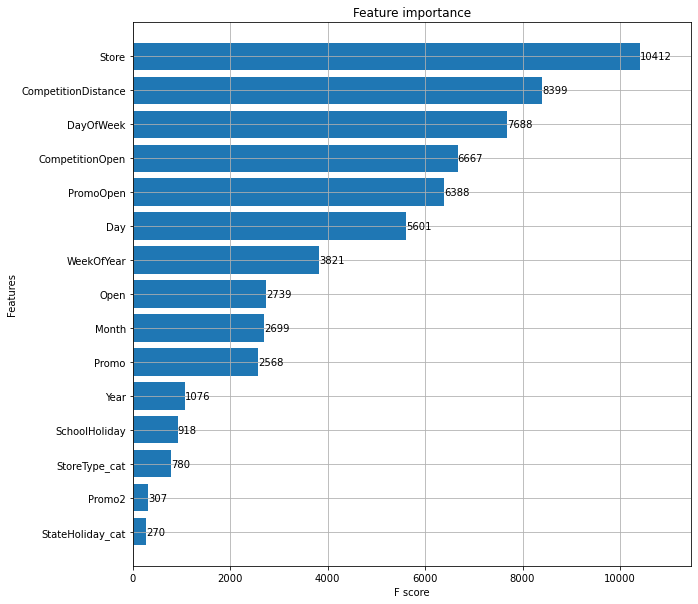

In [62]:

# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost_2, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Model comparison. 

In [69]:

# Comparing performance of above three models - through RMSE
rms_arima = format(float(rms_arima))
rms_prophet_2 = format(float(rms_prophet_2))
rms_xgboost_2 = format(float(rms_xgboost_2))

model_errors = pd.DataFrame({
    "Model": ["SARIMA", "Prophet", "XGBoost"],
    "RMSE": [rms_arima, rms_prophet_2, rms_xgboost_2]
})

model_errors.sort_values(by = "RMSE")

,Model,RMSE
2,XGBoost,1178.5067936106245
1,Prophet,52478290246950.99
0,SARIMA,739.0611671149281



# **Model Comparison & Selection**

## We used the Root Mean Squared Error (RMSE) to evaluate and validate the performance of various models used. Let's see which model performed better and why/why not.

## a) We can see from the above table that SARIMA performs the best followed by XGBoost and Prophet.

## b) It makes sense because SARIMA is designed specifically for seasonal time series data while XGBoost is a general (though powerful) machine learning approach with various applications.

## c) Prophet is a good choice for producing quick forecasts as it doesn't require strong technical skills. It is easy to implement at scale. The reason for its poor performance here is probably because of a lack of data. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

## Based on the above analysis, we'll choose ARIMA as our final model to predict the sales because it gives us the least RMSE and is well suited to our needs of predicting time series seasonal data. We chose ARIMA(1, 1, 1)x(0, 1, 1, 12)12 as the final parameter combination with AIC of 1806.29 and RMSE of 739.06.

# **Conclusions**

## Our task was to predict the sales of each store for next month. We started by exploring the time series data and then did some feature engineering to prepare the data for modelling. Finally, we used various modelling techniques such as SARIMA, Prophet and XGBoost to predict the sales. SARIMA, a model designed specifically for time series performed the best. We also plotted the truth vs predicted sales to understand the performance of model in addition to calcualting squared mean error.

# **Reflection**

## The most interesting thing about the project was that the category of stores having the highest sales don't have the highest sale per customer. It might be because those stores sell small items, which are needed on a daily basis.

## Another interesting thing was that running a promotion for the second time doesn't help in increasing sales. It is probably because customers already purchased whatever they wanted during the first promotional sale.

# **Improvement Areas**:

## We could have used the tranformation techniques to smoothen the data e.g using Moving Average, Log transformation etc. to remove seasonality and trend and make the time series more stationary. After building the model, we would have introduced the behavior of seasonality and trend back to the results. This might have resulted in a better model with a lower RMSE.

## We could also use SARIMAX model that take exogenous variables. These are the variables whose value is determined outside the model and is imposed on the model. In other words, variables that affect a model without being affected by it. For example, Competition Open, Promo Open, etc.